# Scoring model for LendingClub dataset - Technical notebook

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

#created methods for datacleaning
from loan_helper import data_cleaning
from loan_helper import data_converting

#normalization
from sklearn.preprocessing import scale
import statsmodels.api as sm

In [2]:
!ls -lath

total 104
drwxr-xr-x   3 Daniel  staff    96B Oct 21 13:33 __pycache__
drwxr-xr-x   9 Daniel  staff   288B Oct 21 13:31 .
-rw-r--r--@  1 Daniel  staff   2.1K Oct 21 13:31 loan_helper.py
-rw-r--r--   1 Daniel  staff    22K Oct 21 13:30 Technical_Mod4.ipynb
drwxr-xr-x   3 Daniel  staff    96B Oct 21 13:29 .ipynb_checkpoints
drwxr-xr-x   6 Daniel  staff   192B Oct 21 13:26 LendingClub
-rw-r--r--@  1 Daniel  staff   6.0K Oct 21 13:25 .DS_Store
drwxr-xr-x  17 Daniel  staff   544B Oct 21 13:24 ..
-rw-r--r--   1 Daniel  staff    16K Oct 21 13:21 col_selection.xlsx


#### LendingClub data source:

https://www.lendingclub.com/info/download-data.action

In [3]:
description = pd.read_excel('LendingClub/LCDataDictionary.xlsx')

In [ ]:
# from zipfile import ZipFile
# zip_file = ZipFile('LendingClub/LoanStats3d_securev1.csv.zip')
# data_lc = pd.read_csv(zip_file.open('LoanStats3d_securev1.csv'), low_memory=False, header=1)

In [4]:
#read LendingClub loan data from 2015
data_lc = pd.read_csv('LendingClub/LoanStats3d_securev1.csv', low_memory=False, header=1)

In [5]:
#* * * IMPORTANT * * *
#removed two rows with full NAN values
data_lc = data_lc.loc[data_lc.loan_amnt.notnull()]
data_lc.shape

(421095, 150)

## Understanding the columns

In order to understand the columns a dataframe will be created ('desc') with column names, two examples, datatype, and the long description.

In [6]:
col_selection = pd.read_excel('col_selection.xlsx')

In [7]:
col_selection.head()

,Unnamed: 0,col_name,exmp1,exmp2,nan_counts,dtype,Description,Decision,Cause,Unnamed: 9
0,0.0,id,68466961,67715283,0,object,A unique LC assigned ID for the loan listing.,remove,no_effect,NaN
1,1.0,member_id,NaN,NaN,421095,float64,A unique LC assigned Id for the borrower member.,remove,no_effect,NaN
2,2.0,loan_amnt,28000,16000,0,float64,The listed amount of the loan applied for by t...,keep,NaN,NaN
3,3.0,funded_amnt,28000,16000,0,float64,The total amount committed to that loan at tha...,remove,redundant,NaN
4,4.0,funded_amnt_inv,28000,16000,0,float64,The total amount committed by investors for th...,remove,redundant,NaN


In [8]:
selected_col = col_selection.loc[col_selection.Decision == 'keep', 'col_name'].to_list()
selected_col

['loan_amnt',
 'term',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med']

## Feature selection and feature engineering

### First round feauture selection

Originally the dataset contained 150 columns. When we were reducing the features in order to avoid the overfitting the model we selected features according to the following:

- Discarded columns that contained payment or collection information (47 columns)
- Discarded columns that contained information that were not available at the time of credit application
- Discarded features that require too much data processing (typically free input i.e. emp_title)
- Discarded redundant features (subgrade - grade, title - purpose)
- Discarded feauters that contain too much NAN values (mnths_since_last_delinq, mths_since_recent_bc_dlq, mths_since_recent_revol_delinq)

In [9]:
dataset = data_lc.loc[:, selected_col]

In [10]:
dataset.shape

(421095, 21)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421095 entries, 0 to 421094
Data columns (total 21 columns):
loan_amnt                     421095 non-null float64
term                          421095 non-null object
installment                   421095 non-null float64
grade                         421095 non-null object
emp_length                    397278 non-null object
home_ownership                421095 non-null object
annual_inc                    421095 non-null float64
verification_status           421095 non-null object
loan_status                   421095 non-null object
purpose                       421095 non-null object
dti                           421093 non-null float64
delinq_2yrs                   421095 non-null float64
earliest_cr_line              421095 non-null object
fico_range_low                421095 non-null float64
inq_last_6mths                421095 non-null float64
open_acc                      421095 non-null float64
pub_rec                       421

### Converting to data types

- emp_length column to convert numeric and missing values replaced with average
- earliest credit line: convert date to numeric (years)
- revol_util (revolving utilization) convert to numeric

In [12]:
dataset = data_converting(dataset)

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421095 entries, 0 to 421094
Data columns (total 21 columns):
loan_amnt                     421095 non-null float64
term                          421095 non-null object
installment                   421095 non-null float64
grade                         421095 non-null int64
emp_length                    397278 non-null float64
home_ownership                421095 non-null object
annual_inc                    421095 non-null float64
verification_status           421095 non-null object
loan_status                   421095 non-null object
purpose                       421095 non-null object
dti                           421093 non-null float64
delinq_2yrs                   421095 non-null float64
earliest_cr_line              421095 non-null int64
fico_range_low                421095 non-null float64
inq_last_6mths                421095 non-null float64
open_acc                      421095 non-null float64
pub_rec                       4210

## Deciding on the target feature, creating X and y

In [14]:
dataset.loan_status.value_counts()

Fully Paid            307320
Charged Off            77884
Current                34175
Late (31-120 days)       997
In Grace Period          544
Late (16-30 days)        171
Default                    4
Name: loan_status, dtype: int64

#### Meaning of the categories
<b>Fully paid:</b> Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

<b>Current:</b> Loan is up to date on all outstanding payments. 

<b>In Grace Period:</b> Loan is past due but within the 15-day grace period. 

<b>Late (16-30):</b> Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

<b>Late (31-120):</b> Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

<b>Default:</b> Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”.

<b>Charged Off:</b> Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

Sosurce: https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

In [15]:
pd.crosstab(columns=dataset['loan_status'], index=dataset['term'],)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
term,,,,,,,
36 months,42178,3,1,240991,0,0,0
60 months,35706,34172,3,66329,544,171,997


We decided to ignore the 'gray' categories, where there might chance to the recovery of the loan. The 'Current' category contains the 60 months term loans, removing them would panalize the long term loans by increasing the default rate within this category. 

In [16]:
#Select default categories:
dataset.loc[dataset.loan_status == 'Fully Paid', 'default'] = 0
dataset.loc[dataset.loan_status == 'Charged Off', 'default'] = 1
dataset.loc[dataset.loan_status == 'Current', 'default'] = 0

dataset = dataset.loc[dataset.default.notnull()]

In [17]:
#remove loan_status, default replace it
dataset.drop(columns='loan_status', inplace=True)

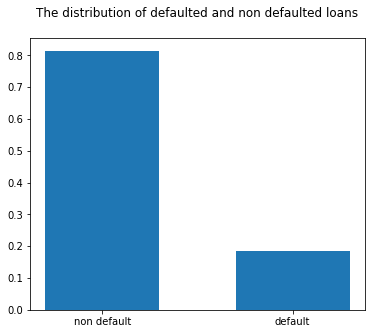

In [18]:
plt.figure(figsize=(6,5))
plt.bar(x=['non default', 'default'], height=dataset.default.value_counts()/len(dataset), width=0.6,)
plt.title('The distribution of defaulted and non defaulted loans\n')
ax=plt.gca();

In [19]:
x_feats = dataset.columns.to_list()
x_feats.remove('default')

In [20]:
len(x_feats)

20

In [164]:
# !!!!! RESET INDEX FOR DATASET
dataset = dataset.reset_index()

In [165]:
X = pd.get_dummies(dataset[x_feats], drop_first=True)

In [166]:
y = dataset.default

In [167]:
y.value_counts()

0.0    341495
1.0     77884
Name: default, dtype: int64

In [168]:
X.head()

,loan_amnt,installment,grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,...,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business
0,20000.0,631.26,6,10.0,85000.0,17.61,1.0,16,705.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,24000.0,507.58,6,NaN,77900.0,10.24,0.0,33,740.0,1.0,...,0,0,0,1,0,0,0,0,0,0
2,27500.0,652.06,5,10.0,195000.0,6.79,0.0,14,700.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,20000.0,602.30,7,9.0,65000.0,18.83,0.0,24,835.0,1.0,...,0,0,1,0,0,0,0,0,0,0
4,8000.0,263.74,6,10.0,42000.0,34.80,0.0,21,700.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [169]:
len(X.columns)

31

## Train-Test Split

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y) #25%

In [171]:
y_train.value_counts()

0.0    256121
1.0     58413
Name: default, dtype: int64

In [172]:
y_test.value_counts()

0.0    85374
1.0    19471
Name: default, dtype: int64

## Further dataleaning separately for train and test

#### Summary:

- annual_inc: in case of annual income we had to handle extreme values (there are many strategies, we were choosing truncating the extreme values to the value of the 99.5 quantile)


In [173]:
X_train = data_cleaning(X_train)

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [174]:
X_test = data_cleaning(X_test)

- Setting Null values as mean for emp_lenth for both test and train

In [175]:
X_test.loc[X_test.emp_length.isna(), 'emp_length'] = round(X_test.emp_length.mean())

In [176]:
X_train.loc[X_train.emp_length.isna(), 'emp_length'] = round(X_train.emp_length.mean())

- Setting Null values as median for revol_util & dti for both test and train 

In [177]:
X_test.loc[X_test.revol_util.isna(), 'revol_util'] = X_test.revol_util.median(skipna=True)

In [178]:
X_train.loc[X_train.revol_util.isna(), 'revol_util'] = X_train.revol_util.median(skipna=True)

In [179]:
X_train.loc[X_train.dti.isna(), 'dti'] = X_train.dti.median(skipna=True)

In [180]:
X_test.loc[X_test.dti.isna(), 'dti'] = X_test.dti.median(skipna=True)

- Truncking income salary for both test and train

In [181]:
inc_trunc = X_test.annual_inc.quantile(q=0.995)
X_test.loc[X_test.annual_inc>inc_trunc, 'annual_inc'] = X_test.annual_inc.quantile(q=0.995)

In [182]:
inc_trunc = X_train.annual_inc.quantile(q=0.995)
X_train.loc[X_train.annual_inc>inc_trunc, 'annual_inc'] = X_train.annual_inc.quantile(q=0.995)

In [183]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104845 entries, 251336 to 13489
Data columns (total 31 columns):
loan_amnt                              104845 non-null float64
installment                            104845 non-null float64
grade                                  104845 non-null int64
emp_length                             104845 non-null float64
annual_inc                             104845 non-null float64
dti                                    104845 non-null float64
delinq_2yrs                            104845 non-null float64
earliest_cr_line                       104845 non-null int64
fico_range_low                         104845 non-null float64
inq_last_6mths                         104845 non-null float64
open_acc                               104845 non-null float64
pub_rec                                104845 non-null float64
revol_bal                              104845 non-null float64
revol_util                             104845 non-null float64
total_a

## Normalization

In [184]:
X_train_norm = scale(X_train, axis = 0) 
X_test_norm = scale(X_test, axis = 0)

 ## Fit a Model

### Imbalance Strategies

- Strategy (I): Giving weight to undersample category

In [104]:
log_reg = LogisticRegression(fit_intercept = False, C = 1, penalty = 'l1', solver='saga', 
                            class_weight = {1 : 4, 0 : 1}, max_iter = 500)
model_log = log_reg.fit(X_train_norm, y_train)
model_log

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight={0: 1, 1: 4}, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
model_log.coef_

array([[-0.33392381,  0.35716937, -0.41004416, -0.00992763, -0.06788454,
         0.12227894,  0.00553149, -0.01591822, -0.16539189,  0.08098984,
         0.0780778 ,  0.02121501, -0.05697135, -0.03845391, -0.03474907,
         0.01236504,  0.25665364, -0.03876879,  0.02742063,  0.10085146,
         0.0581001 ,  0.0790247 ,  0.03849073,  0.05782492,  0.04004543,
        -0.0067869 ,  0.02075672,  0.01283546,  0.00787808,  0.01464979,
         0.01942688]])

In [106]:
model_log.intercept_

array([0.])

In [115]:
y_hat_test = log_reg.predict(X_test_norm)
y_hat_train = log_reg.predict(X_train_norm)

In [116]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0.0    188818
1.0    125716
Name: default, dtype: int64
0.0    0.60031
1.0    0.39969
Name: default, dtype: float64


In [117]:
print(log_reg.score(X_train_norm, y_train), log_reg.score(X_test_norm, y_test))

0.6003103003172948 0.597472459344747


- Strategy (II): Take a random sample from non-default observations 

In [185]:
np.random.seed(100)
random_sample = np.random.choice(X_train_norm.shape[0], size = 100000, replace=False)
X_train_sample = X_train_norm[random_sample]
y_train_sample = y_train[random_sample]

//anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [187]:
random_sample

array([ 59828,  75147,  91537, ...,  13934, 264457, 117705])

In [186]:
StratifiedKFold()

59828     NaN
75147     0.0
91537     1.0
146022    1.0
193594    NaN
41810     0.0
256602    0.0
52871     NaN
72470     0.0
264399    0.0
266445    0.0
157216    1.0
6360      NaN
82516     NaN
312021    0.0
13791     0.0
31723     0.0
236509    NaN
87496     0.0
143014    0.0
91108     NaN
305865    0.0
22889     0.0
154322    0.0
158288    NaN
214866    0.0
139399    0.0
248633    0.0
28242     0.0
43229     NaN
         ... 
308209    0.0
82300     0.0
276059    0.0
9400      1.0
246777    0.0
63772     NaN
138400    0.0
105894    NaN
115652    1.0
170829    0.0
16810     NaN
37164     NaN
223351    NaN
233310    NaN
122727    0.0
91689     NaN
45504     NaN
300317    NaN
105771    0.0
84693     0.0
45016     NaN
203682    NaN
262824    0.0
218749    1.0
247696    NaN
222828    NaN
115902    0.0
13934     NaN
264457    0.0
117705    0.0
Name: default, Length: 100000, dtype: float64

In [160]:
X_train.index

Int64Index([161989, 262572, 374896, 183831,  88198, 415374, 282019, 263326,
             91086,  90898,
            ...
            384119, 400928, 420024, 262613, 368978, 256554, 244107, 192438,
            192596,  30392],
           dtype='int64', length=314534)

In [153]:
y_train_sample.isna().sum()

25291

In [188]:
cv = StratifiedKFold(n_splits= 5, random_state=1000, shuffle=True)

lr_vanilla = LogisticRegression(C = 1e9, 
                                solver = 'newton-cg',
                                max_iter=500)

l2_reg = LogisticRegression(C = 1, 
                            solver = 'newton-cg',
                            penalty='l2',
                            max_iter=500)

l1_reg = LogisticRegression(C = 1, 
                           solver= 'saga', 
                           penalty = 'l1',
                            max_iter=500)

cv_vanilla = cross_validate(estimator=lr_vanilla, 
                            X = X_train, y = y_train,
                            cv = cv, 
                            n_jobs=-1, 
                            return_estimator= True, 
                            return_train_score=True)

cv_l2 = cross_validate(estimator=l2_reg, X = X_train, y = y_train,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)

cv_l1 = cross_validate(estimator=l1_reg, X = X_train, y = y_train,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)

In [140]:
!pip install imblearn

     |████████████████████████████████| 174kB 4.5MB/s eta 0:00:01


In [141]:
from imblearn.over_sampling import SMOTE

In [144]:
type(y_train)

pandas.core.series.Series